# RAG를 이용하여 국방백서를 알려주는 간단한 챗봇 만들기

최근 자연어처리 분야에서 검색 증강 생성 (Retrieval-Augmented Generation, RAG)이 각광받기 시작한 기술입니다.

RAG는 사용자가 질문을 보내면, 사전에 만들어둔 데이터베이스에서 검색하여

검색한 내용을 사용자 입력에 붙여서 (Augment) 모델에게 함께 전달합니다. 

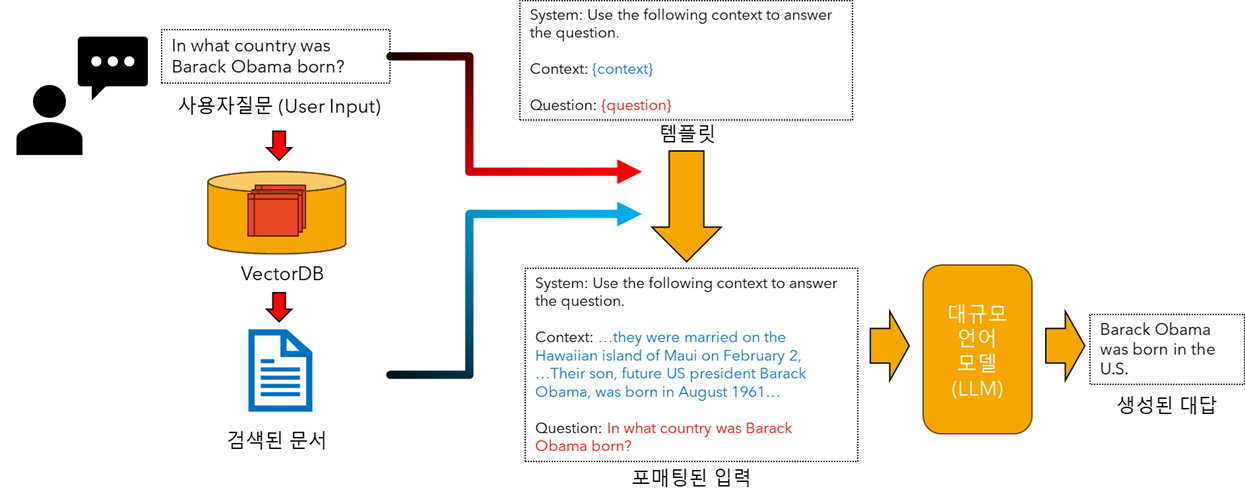

검색해야 하는 문서와 검색 모델을 미리 준비해야하지만, 이를 비용으로

RAG는 다음 대표적인 강점을 가져다 줍니다.

- 데이터베이스를 갱신함으로서 최신 정보를 반영할 수 있습니다.
  - 기존 LLM을 다시 학습하는 것 보다는 비용이 훨씬 낮습니다.
- 언어모델이 사실에 기반한 대답을 하도록 지원합니다.
  - 기존 LLM이 학습된 기억에 의존했던 반면, 사실에 기반한 문맥을 추가 제공합니다.
  - 또한 모델의 크기가 작아 성능이 제한된 LLM에도 좋은 성능을 얻을 수 있습니다.


이하 예제 코드는 VectorDB 라이브러리 ChromaDB와 LLM 고수준 프레임워크 Ollama와 Langchain를 이용하여,
- PDF 파일로 부터 텍스트를 추출하고 이를 바탕으로 VectorDB를 구축한다.
- 

# Requirements

torch는 이미 다운로드 받았다고 가정합니다.

ollama 설치
- https://ollama.com/download

Python 패키지
- pymupdf
- ollama
- chromadb
- huggingface-hub
- sentence-transformers
- transformers
- langchain
- langchain-community
- langchain-ollama


In [2]:
!pip install pymupdf ollama chromadb huggingface-hub sentence-transformers transformers langchain langchain-community langchain-ollama

  Using cached PyMuPDF-1.24.13-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.4 kB)
  Using cached ollama-0.3.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached chromadb-0.5.18-py3-none-any.whl.metadata (6.8 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached sentence_transformers-3.2.1-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.46.2-py3-none-any.whl.metadata (44 kB)
  Using cached langchain-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_community-0.3.5-py3-none-any.whl.metadata (2.9 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5

# Ollama에 모델 등록하기

Ollama는 대규모 언어 모델 (LLM) 추론을 로컬에서 빠르게 실행할 수 있게 해주는 도구입니다.

제공한 학습자료에서 `./models/bllossom3b` 에는 우리가 사용할 자연어 모델 가중치(파라미터)들이 있습니다. 

Ollama에서 사용하기 위해서는 해당 모델을 등록해야 합니다.

```
ollama create bllossom3b -f ./models/bllossom3b/Modelfile
```

In [ ]:
!ollama create bllossom3b -f ./models/bllossom3b/Modelfile

/data2/GoogleDrive/2024/ollama


ollama에 등록한 모델을 Langchain 프레임워크에 연결하여, 자유롭게 대화해볼 수 있습니다.

In [ ]:
import ollama
from langchain_ollama.chat_models import ChatOllama

# Ollama 를 이용해 로컬에서 LLM 실행
## llama3-ko-instruct 모델 다운로드는 Ollama 사용법 참조

model_id = "bllossom3b"
model = ChatOllama(model=model_id, temperature=0)

In [5]:
print(model.invoke("안녕하세요?").content)

안녕하세요! 어떻게 도와드릴까요?


`bllossom3b`는 한국어에 튜닝된 공개 대규모 언어모델이며, 뒤의 `3b` (3 Billions)는 모델의 크기, 즉 가중치의 개수를 의미합니다.

최근 모델 기조에 비하면 모델크기가 작은편이고, 특정 도메인에 한정된 추가 학습이 이루어지지 않았기 때문에 큰 성능을 기대하기는 어렵지만,

예제를 시연하는데에는 적합한 크기입니다.

# PDF 데이터 (국방백서) 전처리하기

이제 검색 증강 생성 (RAG)를 위한 데이터베이스를 구축해봅시다.

먼저, 검색에 사용할 말뭉치가 필요합니다. 우리가 해결하고자 하는 문제에서 도움이 되는 지식을 포함한 텍스트들이여야 합니다.

말뭉치는 .txt 파일부터, .pdf, .docx, .html 등등을 사용할 수 있습니다.

해당 예제에서는 2022년 국방백서 pdf 파일을 이용하여 RAG를 위한 데이터베이스를 구축해볼 것입니다.

In [14]:
from langchain_community.document_loaders import PyMuPDFLoader

# PyMuPDFLoader 을 이용해 PDF 파일 로드
loader = PyMuPDFLoader("2022 국방백서.pdf")
pages = loader.load()

# 전처리
for page in pages:
    page.page_content = page.page_content.replace("\n", " ").replace("  ", " ").replace(". ", ".\n") 

`pages`변수는 각 페이지를 나누어 저장해둔 리스트입니다.

테스트로 `pages[2]`를 출력해봅시다.

In [15]:
print(pages[2].page_content)

발간사 오늘날 우리 군은 지난 70여 년과 다름없이 당면한 위협으로부터 국가를 보위하는 사명을 지속 수행하는 가운데, 급변하는 안보환경에 효과적으로 대처하기 위해 도약적인 혁신을 이뤄내야 하는 중대한 전환점을 맞고 있습니다.
기존의 전통적 위협에 비전통적 위협이 더해지고, 끊임없는 ‘경쟁(Competition)’과 함께 회색지대 분쟁이 일상화되는 등 안보환경은 갈수록 복잡하고 엄중해지고 있습니다.
미·중 간 전략적 경쟁의 심화, 러시아의 우크라이나 침공 등으로 국제질서의 유동성이 커지고, 주요 군사강국 간의 군비경쟁이 심화되고 있으며, 인도·태평양 지역에 대한 국제사회의 전략적 관여가 증대되고 있습니다.
이런 가운데 북한은 핵·미사일 능력을 지속적으로 고도화하면서 다양한 수단과 방법으로 전략적·전술적 도발을 서슴지 않고 있습니다.
한편, 재난, 테러, 신종 감염병 등 비전통적 안보위협의 중요성이 대두되고 있으며, 우주·사이버·전자기 등 새로운 영역에서의 우위를 향한 경쟁도 심화되고 있습니다.
특히, 첨단과학기술의 발전은 안보의 패러다임 변화를 촉발하고 있습니다.
대내적으로는 병역자원이 급감하고, 적정 수준의 국방예산 확보가 어려워지고 있으며, 군에 대한 국민적 기대와 요구는 증가하고 있습니다.
이러한 안보환경 속에서 우리 군은 전략적 우선순위에 입각한 ‘선택과 집중’을 통해 ‘기회요인’을 최대한 활용하고 ‘도전요인’을 극복하기 위한 노력을 강화하고 있습니다.
첫째, 복합적 안보위협에 대한 ‘통합·능동 방위’가 가능한 ‘전방위 국방태세를 확립’해 나가고 있습니다.
지속 가능한 평화는 상대의 선의가 아닌 힘의 우위에 의해 달성 가능하다는 신념 아래 우리 군은 북한의 진화하는 위협에 적시적·효과적으로 대처 가능한 대북 군사대비태세를 더욱 강화해 나갈 것입니다.
둘째, 경쟁 우위의 군사능력을 갖춘 ‘첨단과학기술 기반의 정예강군’을 건설하기 위해 ‘국방혁신 4.0’을 강력히 추진하고 있습니다.
미래 안보환경에 부합하는 선도적 군사전략과 작전개념을 발전시키고, AI 기반

다음은 각 페이지를 짧은 문장으로 쪼개는 과정입니다.

짧은 문장으로 나누어지고 나면, 이것이 DB에 각각 저장되는 단위, 문서가 됩니다.

- `chunk_size`: 자르는 문서의 크기입니다.
- `chunk_overlap`: 문서를 자를 때 인접한 두 문서가 해당 개수만큼 겹치게 자릅니다.

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 페이지의 텍스트들을 더 작은 단위로 자르기
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=256,
    chunk_overlap=32,
)
docs = text_splitter.split_documents(pages)

In [18]:
# 문서의 개수
len(docs)

2550

테스트로 `docs[0]`을 출력해봅시다.

In [19]:
print(docs[0])

page_content='발간사 오늘날 우리 군은 지난 70여 년과 다름없이 당면한 위협으로부터 국가를 보위하는 사명을 지속 수행하는 가운데, 급변하는 안보환경에 효과적으로 대처하기 위해 도약적인 혁신을 이뤄내야 하는 중대한 전환점을 맞고 있습니다.
기존의 전통적 위협에 비전통적 위협이 더해지고, 끊임없는 ‘경쟁(Competition)’과 함께 회색지대 분쟁이 일상화되는 등 안보환경은 갈수록 복잡하고 엄중해지고 있습니다.' metadata={'source': '2022 국방백서.pdf', 'file_path': '2022 국방백서.pdf', 'page': 2, 'total_pages': 408, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Aspose Ltd.', 'producer': 'Aspose.PDF for .NET 19.3', 'creationDate': "D:20230216093523+09'00'", 'modDate': "D:20230216093524+09'00'", 'trapped': ''}


# 벡터 저장소 생성

벡터 저장소 (Vector Store, VectorDB)란 텍스트, 이미지, 음성, 센서데이터 등 다양한 종류의 데이터들을 벡터로 변환하여 색인 (indexing)한 뒤

색인된 벡터를 바탕으로 빠르게 검색할 수 있게 해주는 모듈입니다.

우리가 만들 것은 국방백서에 대한 질문이 입력으로 들어왔을 때, 질문에 관련된 정보를 빠르게 찾아내는 벡터저장소를 만들고자 하는 것입니다.

이하 코드는 `bge-m3` 모델을 이용하여 문서를 벡터화하고 ChromaDB를 이용하여 벡터 저장소를 만드는 예제입니다.

(실행하면 오래 걸리므로, 미리 만들어진 결과물을 사용할 것입니다.)

In [ ]:
"""
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import os

# 문장을 임베딩으로 변환하고 벡터 저장소에 저장
embeddings = HuggingFaceEmbeddings(
    model_name='BAAI/bge-m3',
    model_kwargs={'device':device},
    encode_kwargs={'normalize_embeddings':True},
)

# 벡터 저장소 경로 설정
## 현재 경로에 'vectorstore' 경로 생성
vectorstore_path = 'vectorstore'
os.makedirs(vectorstore_path, exist_ok=True)

# 벡터 저장소 생성 및 저장
vectorstore = Chroma.from_documents(docs, embeddings, persist_directory=vectorstore_path)
#vectorstore = Chroma(embedding_function=embeddings, persist_directory=vectorstore_path)

# 벡터스토어 데이터를 디스크에 저장
vectorstore.persist()
print("Vectorstore created and persisted")
"""

## 만들어진 벡터 저장소 불러오기

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# 저장된 VectorStore 로드
embeddings = HuggingFaceEmbeddings(
    model_name='BAAI/bge-m3',
    model_kwargs={'device':device},
    encode_kwargs={'normalize_embeddings':True},
)
vectorstore_path = 'vectorstore'
vectorstore = Chroma(embedding_function=embeddings, persist_directory=vectorstore_path)



C:\Users\xaiseung24\AppData\Local\Temp\ipykernel_11916\3073514720.py:16: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=embeddings, persist_directory=vectorstore_path)
C:\Users\xaiseung24\AppData\Local\Temp\ipykernel_11916\3073514720.py:21: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model = ChatOllama(model="bllossom3b", temperature=0)


# 국방백서 챗봇 파이프라인 구축하기

## 언어모델 불러오기 + 검색 모듈 초기화

Ollama로 등록한 `bllossom3b` 모델을 불러오고, 벡터 저장소를 검색모듈로 변환합니다.

In [ ]:
from langchain_community.chat_models import ChatOllama

# Ollama 를 이용해 로컬에서 LLM 실행
## llama3-ko-instruct 모델 다운로드는 Ollama 사용법 참조

model = ChatOllama(model="bllossom3b", temperature=0)
retriever = vectorstore.as_retriever(search_kwargs={'k': 4})

## 챗봇 파이프라인 구축

- 대화용 프롬프트를 생성합니다.
  - 중괄호롤 묶인 키워드 (예: `{context}`)가 프롬프트의 빈칸(placeholder)가 되어, 입력을 키워드에 대응시켜 이 자리를 채우도록 할 수 있습니다.
- 프롬프트에 검색모듈의 검색 결과와 사용자의 입력을 대응시키도록 연결합니다.
- 이를 모델에 연결하고 표준 출력을 사용하도록 합니다.
- invoke() 메소드를 사용하여, 챗봇을 이용해봅니다.

In [23]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


# Prompt 템플릿 생성
template = '''친절한 챗봇으로서 상대방의 요청에 최대한 자세하고 친절하게 답하세요. 모든 대답은 한국어(Korean)으로 대답하세요.
다음 문맥(context)는 질문에 도움이 될 수도 있고 아닐 수도 있습니다. 문맥 내애서 북한의 내용인지 남한의 내용인지 잘 구분하세요. 문맥을 바탕으로 알 수 없다면 모르겠다고 답변하세요.

context:
{context}

Question: {question}
'''
prompt = ChatPromptTemplate.from_template(template)

# 검색된 문서 텍스트 전처리
def format_docs(docs):
    return '\n\n\n'.join([f"## Docs{i+1}\n{d.page_content}" for i, d in enumerate(docs)])

# 검색 체인 - 검색 모듈과 사용자 입력을 정해진 placeholder에 배정한다.
retrieve_chain = {'context': retriever | format_docs, 'question': RunnablePassthrough()} | prompt
# RAG Chain 연결
rag_chain = (
    retrieve_chain
    | model
    | StrOutputParser()
)

# Chain 실행
query = "국제 사회의 안보 불확실성이 증대된 이유가 무엇입니까?"
answer = rag_chain.invoke(query)

print("Query:", query)
print("Answer:", answer)

Query: 국제 사회의 안보 불확실성이 증대된 이유가 무엇입니까?
Answer: 국제사회에서의 안보 불확실성은 여러 가지 요인에 의해 증대되고 있습니다. 주요한 이유는 다음과 같습니다.

1. **강대국의 힘 경쟁**: 강대국 간의 전략적 경쟁이 심화되어 국제사회의 안보 불확실성이 증대되고 있습니다. 특히, 러시아의 우크라이나 침공은 이와 같은 경쟁의 심화를 초래했습니다.
2. **중동지역 관여 점진 적 축소**: 미국이 중동지역에 대한 관여를 점진적으로 축소하고 있으며, 이는 국제사회의 안보 불확실성을 증대시키는 요인입니다.
3. **중국과 러시아의 영향력 확대**: 중국과 러시아가 영향력을 확대하면서 국제사회에서의 안보 불확실성이 증가하고 있습니다.
4. **코로나19 장기 화로 인한 경제난 악화**: 코로나19 장기화로 인해 세계 경제는 어려움을 겪고 있으며, 이는 국제사회의 안보 불확실성을 증대시키는 요인입니다.
5. **예멘과 시리아의 정세 불안 지속**: 예멘과 시리아와 같은 지역에서의 정세 불안은 국제사회에서의 안보 불확실성을 증가시킵니다.
6. **사이버 위협 증가**: 북한의 사이버 공격과 국제 해커조직의 랜섬웨어 유포 등은 각종 사이버 위협으로 인해 사회적 혼란이 증가하고 있습니다.

이러한 요인들은 개별 국가나 일부 지역만의 노력으로 해결할 수 없으며, 세계 각국이 공동의 위기를 극복하기 위한 국제공조와 상호협력을 강화해야 합니다.




<hr>


우리의 질문에 대해서 문서 검색이 어떻게 이루어졌고 모델이 받는 입력이 어떻게 되었는지 확인해봅시다.

In [6]:
print(retrieve_chain.invoke(query).to_string())

Human: 친절한 챗봇으로서 상대방의 요청에 최대한 자세하고 친절하게 답하세요. 모든 대답은 한국어(Korean)으로 대답하세요.
다음 문맥(context)는 질문에 도움이 될 수도 있고 아닐 수도 있습니다. 문맥 내애서 북한의 내용인지 남한의 내용인지 잘 구분하세요. 문맥을 바탕으로 알 수 없다면 모르겠다고 답변하세요.

context:
## Docs1
008    2022 국방백서 1.
국제사회의 안보 불확실성 증대 미·중 간 전략적 경쟁의 심화, 러시아의 우크라이나 침공 등 강대국 간 힘의 경쟁으로  국제사회의 안보 불확실성이 증대되고 있다.


## Docs2
또한, 미국의 중동지역에 대한 관여의 점진 적 축소, 중국과 러시아의 영향력 확대, 예멘과 시리아의 정세 불안 지속, 코로나19 장기 화로 인한 경제난 악화 등으로 안보 불안감이 증대되고 있으며, 기존의 종파·국가 간 협 력과 경쟁 관계가 재편되는 모습을 보이고 있다.


## Docs3
또한, 북한의 글로벌 암호화폐 시장에 대한 사이버 공격, 국제 해커조직의  랜섬웨어 유포와 디도스(DDoS: Distributed Denial of Service) 공격 등 각종 사이버  위협으로 인한 사회적 혼란도 증가하고 있다.
이러한 비전통적인 안보위협은 개별 국가나 일부 지역만의 노력으로 해결할 수 없다 는 인식 하에 세계 각국은 공동의 위기를 극복하기 위한 국제공조와 상호협력을 강화하 고 있다.


## Docs4
2022년 2월 러시아의 우크라이나 침공으로 시작된 전쟁이 장기화되면서 다수의 민간 인 사상자가 발생하고 있으며, 전 세계의 에너지 공급과 식량 수급에도 심각한 위기를  초래하고 있다.
미국 및 유럽지역 국가들은 러시아의 위협에 대응하여 북대서양조약기 미·중 간 전략적 경쟁 심화, 러시아의 우크라이나 침공 등 안보환경의 변화로 국제사회의 안보 불확실 성이 커지고 있다.

Question: 국제 사회의 안보 불확실성이 증대된 이유가 무엇입니까?





<hr>

또 다른 질문 예시입니다.

In [7]:
query = "주한미군에 대해서 알려주세요."
answer = rag_chain.invoke(query)

print("Query:", query)
print("Answer:", answer)

Query: 주한미군에 대해서 알려주세요.
Answer: 주한미군은 미국의 군사력 중 하나로, 한국에 위치해 있으며 한국 방위와 안정성을 위해 중요한 역할을 하고 있습니다. 주한미군은 여러 가지 조직과 부대로 구성되어 있으며, 주요 조직과 보유 전력은 다음과 같습니다.

1. **주한미군사령부 (US Forces Korea)**: 주한미군의 최고 지휘 기관으로, 유엔군사령관과 한미연합군사령관을 겸임합니다.
2. **주한미해병대사령부 (US Marine Corps Forces Korea)**: 해병대의 한국 진출 기지와 주요 연대 부대를 담당합니다.
3. **주한미해군사령부 (US Pacific Command, US 7th Fleet)**: 해군의 한국 진출 기지와 주요 연대 부대를 담당합니다.
4. **주한미 공군사령부 (US Air Forces Korea)**: 공군의 한국 진출 기지와 주요 연대 부대를 담당합니다.
5. **주한미해병대사령부 (US Marine Corps Forces Korea)**: 해병대의 한국 진출 기지와 주요 연대 부대를 담당합니다.
6. **주한미특수전사령부 (US Special Operations Command Korea)**: 특수전사부대의 한국 진출 기지와 주요 연대 부대를 담당합니다.
7. **주 한미우주군사령부 (US Space Force Forces Korea)**: 우주군의 한국 진출 기지와 주요 연대 부대를 담당합니다.

주한미군은 다양한 군사적 역량을 보유하고 있으며, 한국 방위와 안정성을 위해 중요한 역할을 하고 있습니다. 주한미군의 주요 전력은 다음과 같습니다:

- **전투기**: 미7공군사령부에서 운영하는 전투기 90여 대
- **헬기**: 주한미해병대사령부와 주한미해군사령부에서 운영하는 헬기 40여 대
- **장갑차**: 주한미특수전사령부에서 운영하는 장갑차 280여 대
- **야포/다련장**: 주한미해병대사령부와 주한미해군사령부에서 운영하는 야포 및 다련장 10/40여 문

주한미군은 한국의 방위와 안정성

In [8]:
print(retrieve_chain.invoke(query).to_string())

Human: 친절한 챗봇으로서 상대방의 요청에 최대한 자세하고 친절하게 답하세요. 모든 대답은 한국어(Korean)으로 대답하세요.
다음 문맥(context)는 질문에 도움이 될 수도 있고 아닐 수도 있습니다. 문맥 내애서 북한의 내용인지 남한의 내용인지 잘 구분하세요. 문맥을 바탕으로 알 수 없다면 모르겠다고 답변하세요.

context:
## Docs1
주한미군사령부는 미8군사령부, 주한미해군사령부, 주한미 공군사령부, 주한미해병대사령부, 주한미특수전사령부, 주 한미우주군사령부로 편성되어 있다.
주한미군사령관은 유엔군사령관과 한미연합군사령 관을 겸임하고 있다.
주요 조직과 보유전력은 [도표 3-5]와 같다.


## Docs2
이 법안에서 미국은 한미동맹 강화차원에서 ‘평화롭고 안정된 한반도’라는 공통의 목 표를 지원하기 위해 주한미군 28,500명을 유지하고 미군의 모든 군사적 역량을 활용하 여 확장억제를 제공한다는 공약을 명시하였다.


## Docs3
미8군사령부 주한미해병대사령부 주한미해군사령부 19지원사 35방공여단 1통신여단 501정보여단 65의무여단 미2사단 주한미군사령부 51전투비행단  8전투비행단  미7공군사령부 주한미특수전사령부 병력 2만 8,500여 명 패트리어트 60여 기 90여 대 전투기 헬기 40여 대 장갑차 280여 대 야포/다련장 10/40여 문 주한미우주군사령부


## Docs4
한국은 토지와 시설을 주한미군에 제 공하고 미국은 한국에 군사 및 경제 지원을 제공하였으며, 주한미군이 한국 방위를 주도하였다.
하지만 한국의 베트남전 참전을 계기로  한미 군사관계는 상호보완적 동맹관계로 발전하였다.

Question: 주한미군에 대해서 알려주세요.

